# Εργασία 3 - Συνδυασμός Μοντέλων

Κωνσταντίνος Ευθυμιάδης<br>
ΑΕΜ: 240

## Εισαγωγή Βιβλιοθηκών

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error

## Δεδομένα tickers δολαρίου τελευταίας πενταετίας

In [2]:
ticker_symbol= "DX-Y.NYB"
ticker= yf.Ticker(ticker_symbol)
df= ticker.history(period="5y").reset_index(drop=False)
df= df.drop(columns=["Volume", "Dividends", "Stock Splits"])
df

,Date,Open,High,Low,Close
0,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999
1,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003
2,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003
3,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000
4,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001
...,...,...,...,...,...
1252,2025-10-29 00:00:00-04:00,98.739998,99.360001,98.620003,99.220001
1253,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999
1254,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003
1255,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003


## Πρώτο Ερώτημα

### Δημιουργία Γραφήματος

In [3]:
fig = px.line(
    df,
    x='Date',
    y=['Open', 'High', 'Low', 'Close'],
    title='USD Price',
    labels={'value': 'Price (USD)', 'Date': 'Date'}
)

fig.update_layout(height=600)
fig.show()

## Δεύτερο Ερώτημα

In [4]:
window = 30

df_for_rolling= pd.DataFrame({'Date': df['Date']})

columns = ['Open', 'High', 'Low', 'Close']
for column in columns:
    df_for_rolling[column] = df[column].rolling(window=window).mean()

df_for_plot= df_for_rolling.melt(
    id_vars= 'Date',
    value_vars= columns,
    var_name= 'Series',
    value_name= 'rollingMean'
)

fig = px.line(
    df_for_plot,
    x='Date',
    y='rollingMean',
    color='Series',
    title=f'Rolling Mean ({window}-day)'
)

fig.update_layout(height=600)
fig.show()

Παρατηρώντας το παραπάνω βοηθητικό διάγραμμα, αντιλαμβάνεται ότι η μέση τιμή των ιδιοτήτων δεν παραμένει σταθερή. Άρα, οι χρονοσειρές είναι μη-στατικές

In [5]:
from statsmodels.tsa.stattools import adfuller
columns = ['Open', 'High', 'Low', 'Close']

p_values= []
for column in columns:
  result = adfuller(df[column], autolag='AIC')
  p_values.append(result[1])

p_values

[np.float64(0.40105914199783693),
 np.float64(0.39662635505724575),
 np.float64(0.4154132378869449),
 np.float64(0.4276550603504972)]

Επιπλέον, παρατηρούμε ότι η p_value για κάθε μία ιδιότητα ξεχωριστά είναι μεγαλύτερη του 0.05. Επομένως, όλες οι χρονοσειρές είναι μη-στατικές

## Τρίτο Ερώτημα

Όταν εκπαιδεύουμε έναν Regressor σε μη στατικές χρονοσειρές, τότε μπορούν να δημιουργηθούν προβλήματα. Οι εξαρτήσεις του χρόνου δεν θα λαμβάνονται υπόψη, με αποτέλεσμα να μην μπορεί ο αλγόριθμος να εντοπίσει τα μοτίβα που δημιουργούνται από τις αυξομειώσεις του δολαρίου. Δεν μπορεί να αντιληφθεί την εποχικότητα, κατά την οποία υπάρχουν κάποια μοτίβα ανά κάποιους μήνες ή εποχές (πιθανόν αυξημένη δραστηριότητα τις εορταστικές περιόδους), ούτε επίσης και την τάση μιας συγκεκριμένης χρονικής περιόδου.

## Τέταρτο Ερώτημα

Η τάση του δολαρίου τον μήνα Ιούνιο είχε κυρίως καθοδική τάση με κάποιες αυξομειώσεις.
Πιθανές αιτίες πρέπει να είναι η ανησυχία για το δημοσιονομικό έλλειμμα των ΗΠΑ

Τον Ιούλιο όμως παρατηρείται ανοδική τάση, με ενδιάμεσες αυξομειώσεις.
Αποτελεί την πρώτη μηναία άνοδο στην διάρκεια του 2025. Οι ανησυχίες για εμπορικές εντάσεις ή για ενδεχόμενες παγκόσμιες διαταραχές ώθησαν κάποιους επενδυτές στο δολάριο ως ασφαλή επιλογή. Επιπλέον, τα στοιχεία για την αγορά εργασίας των ΗΠΑ ήταν καλύτερα από τις προσδοκίες, κάτι το οποίο ενίσχυσε την εκτίμηση ότι η Federal Reserve δεν θα προβεί άμεσα σε μείωση επιτοκίων

## Πέμπτο Ερώτημα

Η πρόβλεψη της τιμής close του δολαρίου για την επόμενη ημέρα, με πληροφορία μόνο τα σημερινά open, high, low και close δεν είναι δυνατή. Η πρόβλεψη χρονοσειρών αποτελεί ένα σύνθετο πρόβλημα το οποίο επηρεάζεται και από ένα πλήθος απρόβλεπτων παραγόντων, όπως για παράδειγμα οικονομικά νέα και πολιτικές αποφάσεις. Επιπλέον, απαιτούνται περισσότερα δεδομένα, πέρα από αυτά της τωρινής ημέρας, με σκοπό τον εντοπισμό τάσης, εποχικότητας και κυκλικότητας.

## Έκτο Ερώτημα

Όχι, δεν έχει νόημα να πραγματοποιηθεί τυχαίος διαχωρισμός των δεδομένων σε train και test. Στις χρονοσειρές τα δεδομένα εξαρτώνται από τον χρόνο, αφού οι χρονικά επόμενες τιμές καθορίζονται από αυτές που που είναι χρονικά προηγούμενες. Επιπλέον, αν γίνει τυχαίος διαχωρισμός, το μοντέλο θα εκπαιδευτεί και με δεδομένα από μελλοντικές τιμές, ενώ θα προσπαθεί να προβλέψει τιμές από προηγούμενες χρονικές περιόδους, κάτι το οποίο δεν ανταποκρίνεται στην πραγματικότητα.

## Έβδομο Ερώτημα

### Διαχωρισμός Δεδομένων σε train και test

In [6]:
df_train= df[df['Date']<'2024-01-01']
df_test= df[(df['Date']>='2024-01-01') & (df['Date']<'2025-01-01')]

df_train= df_train.drop(columns=['Date'])
df_test= df_test.drop(columns=['Date'])

## Όγδοο Ερώτημα

### Δημιουργία Συνάρτησης

In [7]:
def from_dataframe_to_arrays(df, n):
  input_x= []
  target_y= []

  columns_names= ['Open', 'High', 'Low', 'Close']

  for i in range(len(df) - n):
    temp_input_x= df.iloc[i : i+n][columns_names]
    temp_target_y= df.iloc[i+n]['Close']

    input_x.append(temp_input_x)
    target_y.append(temp_target_y)

  return np.array(input_x), np.array(target_y)

## Ένατο Ερώτημα

Αν επιθυμούμε να προβλέψουμε την τιμή για την επόμενη ημέρα, το μέγεθος του timeframe N θα πρέπει να είναι μικρό. Με αυτό τον τρόπο, θα μπορεί να επηρεαστεί περισσότερο με τις πρόσφατες εξελίξεις, προσαρμόζοντας στην τάση και την εποχικότητα που επικρατεί αυτήν την περίοδο.<br>
Αντίθετα, αν επιθυμούμε να προβλέψουμε την τιμή για μια μέρα με πιο μακρινό ορίζοντα, το μέγεθος N θα πρέπει να μεγαλώσει, ώστε το μοντέλο να μπορεί να διακρίνει καλύτερα τις τάσεις και εποχικές διακυμάνσεις για μεγαλύτερο εύρος ημερών

## Δέκατο Ερώτημα

### Δημιουργία train_set και test_set

In [8]:
n= 5
x_train, y_train= from_dataframe_to_arrays(df_train, n)
x_test, y_test= from_dataframe_to_arrays(df_test, n)

### Αλλαγή shape στα x_train και x_test, ώστε να μπορούν να εισαχθούν στα μοντέλα μηχανικής μάθησης

In [9]:
number_features= df_train.shape[1]

x_train= x_train.reshape((x_train.shape[0], number_features*n))
x_test = x_test.reshape((x_test.shape[0], number_features*n))

### Έλεγχος ότι έγιναν σωστά οι μετατροπές σε διανύσματα

In [10]:
print("Shape of:")
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

Shape of:
x_train:  (787, 20)
y_train:  (787,)
x_test:  (247, 20)
y_test:  (247,)


### Εκτύπωση πρώτου input του x_train

In [11]:
print("First input of x_train:", x_train[0])

First input of x_train: [93.33999634 93.55000305 92.48999786 92.52999878 92.56999969 92.81999969
 92.18000031 92.23000336 92.23999786 92.95999908 92.12999725 92.73000336
 92.76000214 92.97000122 92.59999847 92.75       92.69999695 93.20999908
 92.61000061 93.04000092]


## Ενδέκατο Ερώτημα

### Υπολογισμός MAE

#### Χρήση Linear Regressor

In [12]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train, y_train)

y_pred_at_test= linear_regression_model.predict(x_test)
y_pred_at_train= linear_regression_model.predict(x_train)

mae_train_linear= mean_absolute_error(y_train, y_pred_at_train)
mae_test_linear= mean_absolute_error(y_test, y_pred_at_test)

print("MAE for train is: ", mae_train_linear)
print("MAE for test is: ", mae_test_linear)

MAE for train is:  0.34536750446372355
MAE for test is:  0.28457953197664765


#### Χρήση Random Forest Regressor

In [13]:
seed= 0

random_forest_model= RandomForestRegressor(random_state=seed)
random_forest_model.fit(x_train, y_train)

y_pred_at_test= random_forest_model.predict(x_test)
y_pred_at_train= random_forest_model.predict(x_train)

mae_train_randomForest= mean_absolute_error(y_train, y_pred_at_train)
mae_test_randomForest= mean_absolute_error(y_test, y_pred_at_test)

print("MAE for train is: ", mae_train_randomForest)
print("MAE for test is: ", mae_test_randomForest)

MAE for train is:  0.14730088685943327
MAE for test is:  0.31990977576869734


#### Χρήση Bagging Regressor

In [14]:
seed=0

bagging_model= BaggingRegressor(estimator= LinearRegression(), random_state= seed)
bagging_model.fit(x_train, y_train)

y_pred_at_test= bagging_model.predict(x_test)
y_pred_at_train= bagging_model.predict(x_train)

mae_train_bagging= mean_absolute_error(y_train, y_pred_at_train)
mae_test_bagging= mean_absolute_error(y_test, y_pred_at_test)

print("MAE for train is: ", mae_train_bagging)
print("MAE for test is: ", mae_test_bagging)

MAE for train is:  0.3455240978981919
MAE for test is:  0.2833893596959626


#### Χρήση XG-Boost Regressor

In [15]:
seed= 0

xgbBoost_model = XGBRegressor(random_state=seed)
xgbBoost_model.fit(x_train, y_train)

y_pred_at_test= xgbBoost_model.predict(x_test)
y_pred_at_train= xgbBoost_model.predict(x_train)

mae_train_xgb= mean_absolute_error(y_train, y_pred_at_train)
mae_test_xgb= mean_absolute_error(y_test, y_pred_at_test)

print("MAE for train is: ", mae_train_xgb)
print("MAE for test is: ", mae_test_xgb)

MAE for train is:  0.02159788526755579
MAE for test is:  0.3802515871611684


#### Χρήση Stacking Regressor

In [16]:
stacking_model= StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(random_state=seed)),
        ('dt', DecisionTreeRegressor(random_state=seed))
    ],
    final_estimator=LinearRegression()
)
stacking_model.fit(x_train, y_train)

y_pred_at_test= stacking_model.predict(x_test)
y_pred_at_train= stacking_model.predict(x_train)

mae_train_stacking= mean_absolute_error(y_train, y_pred_at_train)
mae_test_stacking= mean_absolute_error(y_test, y_pred_at_test)

print("MAE for train is: ", mae_train_stacking)
print("MAE for test is: ", mae_test_stacking)

MAE for train is:  0.3582497382921459
MAE for test is:  0.324565463534584


### Κατασκευή Bar Plot

In [17]:
all_mae_at_test= [mae_test_linear, mae_test_randomForest, mae_test_bagging, mae_test_xgb, mae_test_stacking]
all_mae_at_train= [mae_train_linear, mae_train_randomForest, mae_train_bagging, mae_train_xgb, mae_train_stacking]
models= ['Linear', 'Random Forest', 'Bagging', 'XGBoost', 'Stacking']

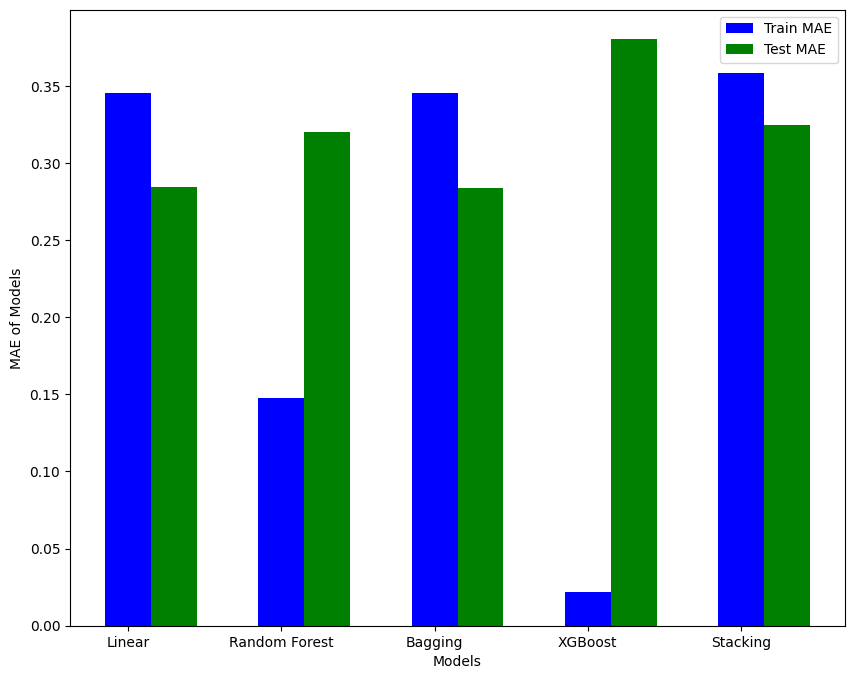

In [18]:
bar_width = 0.3
index = np.arange(len(models))

plt.figure(figsize=(10, 8))
plt.bar(index, all_mae_at_train, bar_width, label='Train MAE', color='blue')
plt.bar(index + bar_width, all_mae_at_test, bar_width, label='Test MAE', color='green')

plt.xlabel('Models')
plt.ylabel('MAE of Models')
plt.xticks(index, models)
plt.legend()
plt.show()

<ul>
  <li><b>Linear Regression:</b> Προσαρμόζει μια ευθεία γραμμή στα δεδομένα, προσπαθόντας να ελαχιστοποιήσει το σφάλμα πρόβλεψης</li>
  <li><b>Random Forest Regressor:</b> Χρησιμοποιεί και συνδυάζει πολλά ανεξάρτητα Decision Trees, λαμβάνοντας υπόψιν του, τον μέσο όρο των προβλέψεών τους</li>
  <li><b>Bagging Regressor:</b> Δημιουργεί πολλά διαφορετικά σύνολα δεδομένων από το αρχικό σύνολο μέσω Δειγματοληψίας με Επανατοποθέτηση. Όλα τα σύνολα έχουν τον ίδιο αριθμό δεδομένων (κάποια δεδομένα επαναλαμβάνονται, ενώ άλλα δεν συμπεριλαμβάνονται καθόλου σε κάποιο σύνολο). Ο αλγόριθμος εφαρμόζεται σε όλα τα σύνολα. Η τελική τιμή είναι είτε η κλάση που συγκεντρώνει τις περισσότερες αποφάσεις μοντέλων είτε ο μέσος όρος των αριθμητικών προβλέψεων των διαφορετικών μοντέλων</li>
  <li><b>XGBoost Regressor:</b> Αποτελεί ένα μοντέλο ενισχυτικής μάθησης. Εκπαιδεύει διαδοχικά Decision Trees, μειώνοντας τα σφάλματα των προηγουμένων, με αποτέλεσμα να πετυχαίνει υψηλότερη ακρίβεια </li>
  <li><b>Stacking Regressor:</b>  Χρησιμοποιείται για τον συνδυασμό μοντέλων πρόβλεψης που προέκυψαν από διαφορετικούς αλγορίθμους μάθησης. Στηρίζεται στην παραγωγή ενός μέτα-μοντέλου, με δεδομένα εκπαίδευσης τις αποφάσεις ενός συνόλου μοντέλων.</li>
</ul>

## Δωδέκατο Ερώτημα

### Εξαγωγή μήνα και ημέρας από την Date

In [19]:
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

Ο μήνας θα συμβάλει στην βελτίωση των προβλέψεων. Η τιμή του δολαρίου εμφανίζει εποχικότητα, αφού ανάλογα την εποχή του έτους μπορεί να εμφανίζονται επαναλαμβανόμενα μοτίβα στη συμπεριφορά της αγοράς. Για παράδειγμα, μπορεί να υπάρχει μήνας που τον χαρακτηρίζει η αυξημένη τουριστική δραστηριότητα. Επομένως, η προσθήκη του μήνα θα βελτιώσει, ενδεχομένως, την ακρίβεια των προβλέψεων.

### Εφαρμογή Φόρμουλας Λογαριθμικών Επιστροφών

In [20]:
columns= ['Open', 'High', 'Low', 'Close']

for column in columns:
  df[f'{column}_log_return']=  np.log(df[column].shift(-1) / df[column])

### Δημιουργία ιστογράμματος

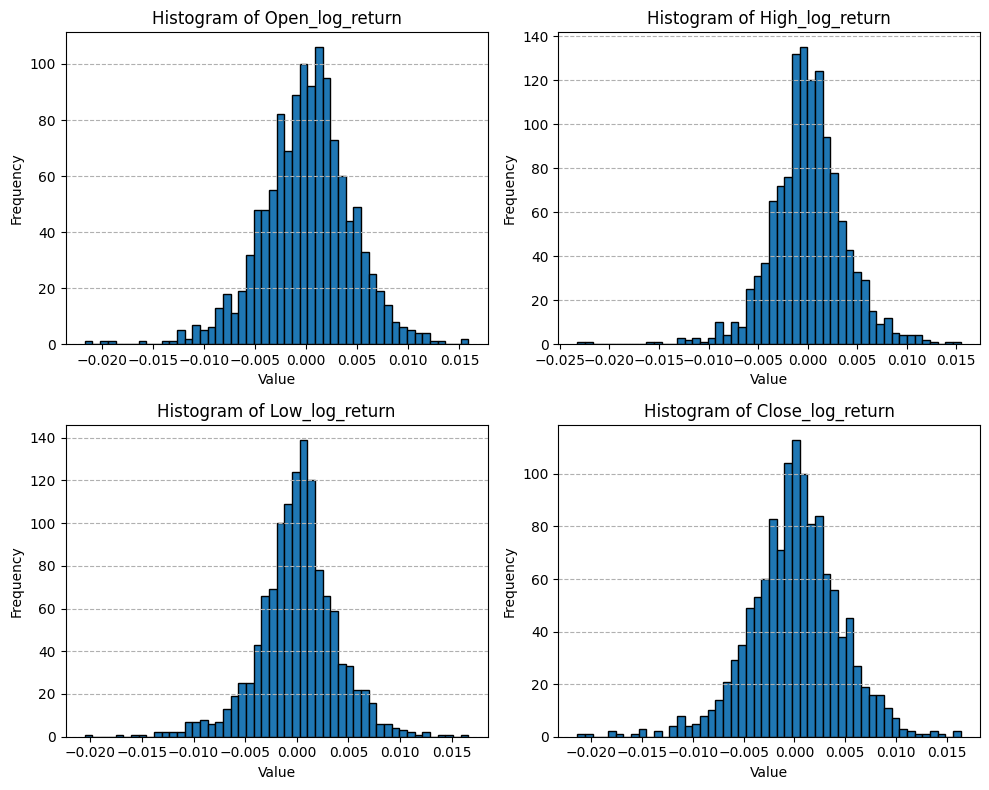

In [21]:
columns= ['Open_log_return', 'High_log_return', 'Low_log_return', 'Close_log_return']

plt.figure(figsize=(10, 8))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[column].dropna(), bins=50, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

### Ανάλυση Πρόβλεψης

Αν κάποιο μοντέλο προβλέψει C<sub>t+1</sub>=0.01, τότε σημαίνει ότι θα υπάρξει αύξηση στην τιμή Close περίπου κατά 1% σε σχέση με την προηγούμενη ημέρα.

Ισχύει:<br>
C<sub>t+1</sub> = ln(C<sub>t+1</sub>/C<sub>t</sub>)<br>
Άρα, 0.01 = ln(C<sub>t+1</sub>/C<sub>t</sub>)
<br>
Επομένως, e<sup>0.01</sup>=C<sub>t+1</sub>/C<sub>t</sub>
<br>
Για C<sub>t</sub>= 0.95$, τότε: C<sub>t+1</sub>= e<sub>o.o1</sub>*0.95
<br>
Επομένως, είναι περίπου ίσο με: 0.9595


### Χωρισμός του συνόλου σε train και test

In [22]:
df_train= df[df['Date']<'2024-01-01']
df_test= df[(df['Date']>='2024-01-01') & (df['Date']<'2025-01-01')]

df_train= df_train.drop(columns=['Date'])
df_test= df_test.drop(columns=['Date'])

### Δημιουργία Timeframe Συνάρτησης

In [23]:
def from_dataframe_to_arrays_2(df, n):
  input_x= []
  target_y= []

  columns_names= ['Open', 'High', 'Low', 'Close', 'Month', 'Day', 'Open_log_return', 'High_log_return', 'Low_log_return', 'Close_log_return']

  for i in range(len(df) - n):
    temp_input_x= df.iloc[i : i+n][columns_names]
    temp_target_y= df.iloc[i+n]['Close']

    input_x.append(temp_input_x)
    target_y.append(temp_target_y)

  return np.array(input_x), np.array(target_y)

### Δημιουργία train_set και test_set

In [24]:
n= 5
x_train, y_train= from_dataframe_to_arrays_2(df_train, n)
x_test, y_test= from_dataframe_to_arrays_2(df_test, n)

### Αλλαγή shape

In [25]:
number_features= df_train.shape[1]

x_train= x_train.reshape((x_train.shape[0], number_features*n))
x_test = x_test.reshape((x_test.shape[0], number_features*n))

#### Χρήση Linear Regressor

In [26]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train, y_train)

y_pred_at_test= linear_regression_model.predict(x_test)
y_pred_at_train= linear_regression_model.predict(x_train)

mae_train_linear= mean_absolute_error(y_train, y_pred_at_train)
mae_test_linear= mean_absolute_error(y_test, y_pred_at_test)

print("MAE for train is: ", mae_train_linear)
print("MAE for test is: ", mae_test_linear)

MAE for train is:  0.018470173958375656
MAE for test is:  0.008687445331263194


#### Χρήση Random Forest Regressor

In [27]:
seed= 0

random_forest_model= RandomForestRegressor(random_state=seed)
random_forest_model.fit(x_train, y_train)

y_pred_at_test= random_forest_model.predict(x_test)
y_pred_at_train= random_forest_model.predict(x_train)

mae_train_randomForest= mean_absolute_error(y_train, y_pred_at_train)
mae_test_randomForest= mean_absolute_error(y_test, y_pred_at_test)

print("MAE for train is: ", mae_train_randomForest)
print("MAE for test is: ", mae_test_randomForest)

MAE for train is:  0.07825628501184397
MAE for test is:  0.12472831139197701


#### Χρήση Bagging Regressor

In [28]:
seed=0

bagging_model= BaggingRegressor(estimator= LinearRegression(), random_state= seed)
bagging_model.fit(x_train, y_train)

y_pred_at_test= bagging_model.predict(x_test)
y_pred_at_train= bagging_model.predict(x_train)

mae_train_bagging= mean_absolute_error(y_train, y_pred_at_train)
mae_test_bagging= mean_absolute_error(y_test, y_pred_at_test)

print("MAE for train is: ", mae_train_bagging)
print("MAE for test is: ", mae_test_bagging)

MAE for train is:  0.01858089978023085
MAE for test is:  0.00868097208528396


#### Χρήση XG-Boost Regressor

In [29]:
seed= 0

xgbBoost_model = XGBRegressor(random_state=seed)
xgbBoost_model.fit(x_train, y_train)

y_pred_at_test= xgbBoost_model.predict(x_test)
y_pred_at_train= xgbBoost_model.predict(x_train)

mae_train_xgb= mean_absolute_error(y_train, y_pred_at_train)
mae_test_xgb= mean_absolute_error(y_test, y_pred_at_test)

print("MAE for train is: ", mae_train_xgb)
print("MAE for test is: ", mae_test_xgb)

MAE for train is:  0.0005592336497131115
MAE for test is:  0.14195955716646635


#### Χρήση Stacking Regressor

In [30]:
stacking_model= StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(random_state=seed)),
        ('dt', DecisionTreeRegressor(random_state=seed))
    ],
    final_estimator=LinearRegression()
)
stacking_model.fit(x_train, y_train)

y_pred_at_test= stacking_model.predict(x_test)
y_pred_at_train= stacking_model.predict(x_train)

mae_train_stacking= mean_absolute_error(y_train, y_pred_at_train)
mae_test_stacking= mean_absolute_error(y_test, y_pred_at_test)

print("MAE for train is: ", mae_train_stacking)
print("MAE for test is: ", mae_test_stacking)

MAE for train is:  0.31603282402167626
MAE for test is:  0.13001395523531253


### Κατασκευή Bar Plot

In [31]:
all_mae_at_test= [mae_test_linear, mae_test_randomForest, mae_test_bagging, mae_test_xgb, mae_test_stacking]
all_mae_at_train= [mae_train_linear, mae_train_randomForest, mae_train_bagging, mae_train_xgb, mae_train_stacking]
models= ['Linear', 'Random Forest', 'Bagging', 'XGBoost', 'Stacking']

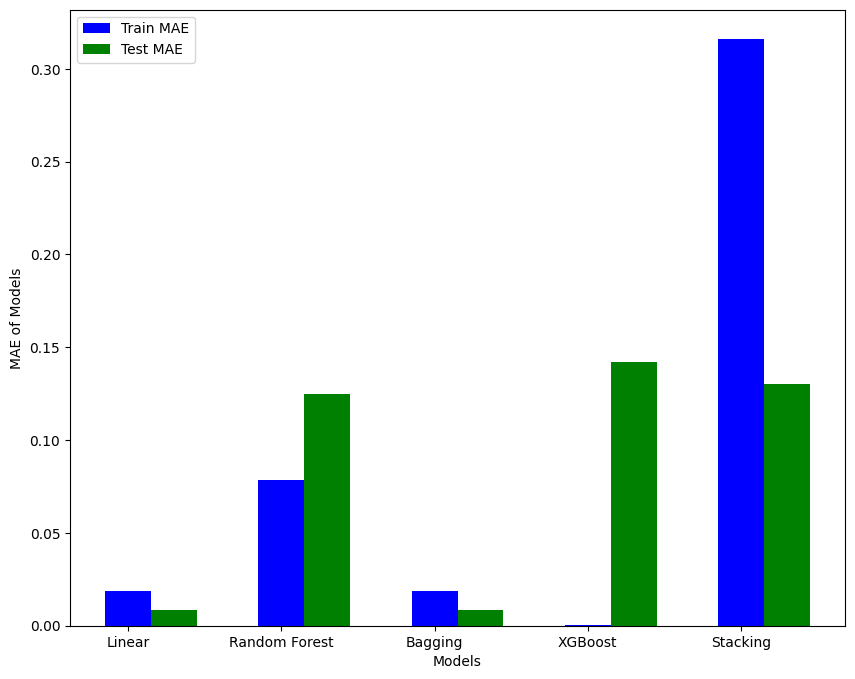

In [32]:
bar_width = 0.3
index = np.arange(len(models))

plt.figure(figsize=(10, 8))
plt.bar(index, all_mae_at_train, bar_width, label='Train MAE', color='blue')
plt.bar(index + bar_width, all_mae_at_test, bar_width, label='Test MAE', color='green')

plt.xlabel('Models')
plt.ylabel('MAE of Models')
plt.xticks(index, models)
plt.legend()
plt.show()